In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rc_tools as rct
import rc_matrices as rcm
import rc_analysis as rca
import sys
import time

from sklearn.metrics import mean_squared_error

from scipy.special import kl_div
from scipy.optimize import fsolve
from scipy.signal import argrelmax
import pdb
import warnings
warnings.filterwarnings("ignore")
np.random.seed(11)
import scipy
import nolds
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

import seaborn as sns
import pandas as pd

In [2]:
fontsize = 24
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["text.usetex"] = True 
plt.rcParams["axes.xmargin"] = 0 
plt.rcParams["axes.titlesize"] = 26 
plt.rcParams["axes.labelsize"] = 26 
plt.rcParams["xtick.labelsize"] = fontsize 
plt.rcParams["ytick.labelsize"] = fontsize
plt.rcParams["xtick.color"] = 'black'
plt.rcParams["ytick.color"] = 'black'
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"  #lmodern

In [3]:
def rank_along_trajectory(wr, wi, a, g, forcing, n, k, tolerance, delX):
    T = forcing.shape[0]
    ranks = np.zeros(T)
    conds = np.zeros(T)
    radii = np.zeros(T)
    uncertainty = np.zeros((n,T))
    def Func(x):
        return np.squeeze(-x.reshape(n,1) + (1-a)*x.reshape(n,1) +\
                          a*g*np.tanh(np.dot(wr,x.reshape(n,1)) +\
                         (np.dot(wi,ueq.reshape(k,1)).reshape(n,1))))
    for i in range(T):
        ueq = forcing[i]
        x0 = np.ones((n,1))*.5
        xeq = (fsolve(Func,x0)).reshape(n,1)
        A = rca.leaky_jacobian(xeq, ueq.reshape(k,1), a, g, Wi, Wr)
        radii[i] = np.max(np.abs(rca.eig_spectrum(A)))
        conds[i] = rca.condition_number(A)[0]
        B = rca.partial_u(xeq, ueq.reshape(k,1), a, g, Wi, Wr)
        uncertainty[:,i] = np.squeeze(np.dot(A,delX))
        Cplus = rca.controllability_matrix(A, B)
        ranks[i] = rca.rank(Cplus, tolerance)
        print(f'Time-step: {i} Rank: {ranks[i]} Uncertainty: {np.linalg.norm(uncertainty):.2f}  CondNum: {conds[i]:.2f}')
    return ranks, uncertainty, conds, radii

def NRMSE(target, pred,std):
    rmse = np.sqrt(mean_squared_error(target, pred))
    return rmse/std

def support(target, pred):
    mn = np.max([np.min(target),np.min(pred)])
    mx = np.min([np.max(target),np.max(pred)])
    return mn, mx

def observability_matrix(A, C):
    pdb.set_trace()
    rows = []
    n = A.shape[0]
    for i in range(n):
        Apower = np.linalg.matrix_power(A,i)
        rows.append(np.dot(C,Apower))
    return np.vstack(rows)

In [5]:
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
signal = np.load('Lxyz_signal.npy')
mu = np.mean(signal[:15000],axis=0)

In [6]:
#p = np.load('Consistent/X_30_params.npy')
#np.where(p[1,:].round(3) == 1.311)
#np.save('Consistent/X_30_paper_params.npy',p[:,36])

In [19]:
pred300 = np.squeeze(np.load('Consistent/X_300_preds.npy'))
pred30 = np.squeeze(np.load('Consistent/X_30_preds.npy'))
target = np.load('Consistent/X_target.npy')
tols = [1/10**x for x in range(0,30)]

In [21]:
minmax = np.max(target[:15000])-np.min(target[:15000])
NRMSE(target[14000:15000],pred30[14000:15000], minmax)

0.18955694178019672

In [18]:
minmax

38.05303464808486

In [15]:
np.var(target[:15000])

62.603370899466185

In [8]:
p = np.load('Consistent/X_30_params.npy')
np.where(p[0].round(2)==.36)

(array([  2,  36,  58, 105, 109, 114]),)

In [9]:
np.where(p[2].round(2)==.87)

(array([ 36,  46,  71,  79, 105, 109, 114]),)

In [10]:
p[:,114]

array([3.56336374e-01, 1.31120099e+00, 8.71888403e-01, 6.90718500e-01,
       3.56911874e+00, 1.00000000e+03, 1.00000000e+00])

In [16]:
a = .33
g = .104
N = 300
K = 1
L = 1
fname = 'Consistent/X_300_Wnet.npy'
Wr, Wi = rca.get_mats(fname, K,N)
x0 = np.zeros((N,1))
u0 = np.zeros((1,1))
A = rca.leaky_jacobian(x0, u0, a, g, Wi, Wr)
B = rca.partial_u(x0, u0, a, g, Wi, Wr)
C = Wi[0,:-L]
Cn = rca.controllability_matrix(A,B)
Cn = Cn/np.max(rca.eig_spectrum(Cn))
#Co = observability_matrix(A,C)
rank_by_tol = []
for i in tols:
    rank_by_tol.append(rca.rank(Cn,i))

[ 0.   0.5  1.   0.5  0.5  1.   0.5  0.5  1.   0.5  0.5  1.   0.5  5.5
 14.5 15.5  9.5  5.5  5.5  6.5  6.   6.   6.5  6.   6.5  6.5  6.   6.
  6.5  7. ]
1e-15
rank v=39
rank v+1=52
Ave 45.5


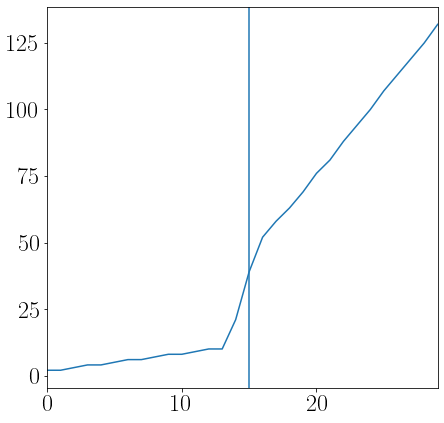

In [17]:
v = 15
print(np.gradient(rank_by_tol))
print(f'{tols[15]}')
print(f'rank v={rank_by_tol[v]}')
print(f'rank v+1={rank_by_tol[v+1]}')
print(f'Ave {(rank_by_tol[v]+rank_by_tol[v+1])/2}')
plt.figure(figsize=(7,7))
plt.plot(rank_by_tol[:])
plt.axvline(v)
plt.show()

In [11]:
a = p[0,114]
g = p[2,114]
N = 30
K = 1
L = 1
fname = 'Consistent/X_30_Wnet.npy'
Wr, Wi = rca.get_mats(fname, K,N)
x0 = np.zeros((N,1))
u0 = np.zeros((1,1))
A = rca.leaky_jacobian(x0, u0, a, g, Wi, Wr)
B = rca.partial_u(x0, u0, a, g, Wi, Wr)
C = Wi[0,:-L]
Cn = rca.controllability_matrix(A,B)
Cn = Cn/np.max(rca.eig_spectrum(Cn))
#Co = observability_matrix(A,C)
rank_by_tol = []
for i in tols:
    rank_by_tol.append(rca.rank(Cn,i))

[2.  1.5 1.5 1.5 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.5 4.  4.  1.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
1e-15
rank v=22
rank v+1=28
Ave 25.0


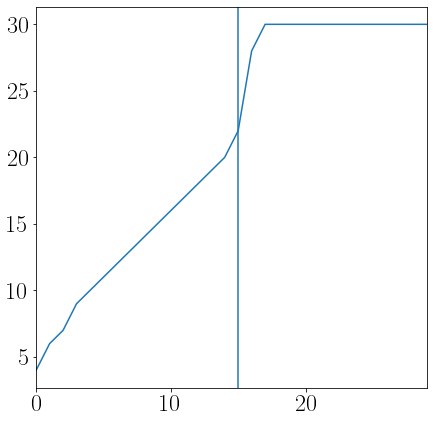

In [12]:
v = 15
print(np.gradient(rank_by_tol))
print(f'{tols[v]}')
print(f'rank v={rank_by_tol[v]}')
print(f'rank v+1={rank_by_tol[v+1]}')
print(f'Ave {(rank_by_tol[v]+rank_by_tol[v+1])/2}')
plt.figure(figsize=(7,7))
plt.plot(rank_by_tol[:])
plt.axvline(v)
plt.show()

In [13]:
tols[v]

1e-15

In [14]:
Wc = np.dot(Cn,Cn.T)
eigenvalues = np.linalg.svd(Wc, compute_uv=False)

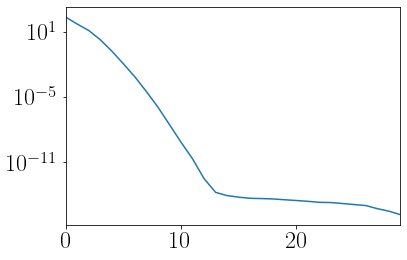

In [15]:
plt.semilogy(eigenvalues)
plt.show()

In [16]:
start, end = 14000,16000
uVecs = np.zeros((N,2000))
for i in range(start,end):
    uVecs[:,i-14000] = Wi[:,0]*target[i]

diffs = np.diff(uVecs, axis=1)
norms = np.zeros(2000)
for i in range(diffs.shape[1]):
    norms[i] = np.linalg.norm(diffs[:,i])
np.argmax(norms)

maxX = diffs[:,772][:,np.newaxis]

In [17]:

#print(f'Tolerance {tols[v]}\t Rank {rank_by_tol[v]}')
#print(f'Tolerance {tols[v+1]}\t Rank {rank_by_tol[v+1]}')

K=1
tval = v+1
start, end= 13900,15000
sig_rks30, uncSig, cNum, sigradius, = rank_along_trajectory( Wr, Wi, a, g,
                                  target[start:end],N, K, tols[tval], maxX)
prd_rks30, uncPrd, cNum, prdradius = rank_along_trajectory( Wr, Wi, a, g,
                                  pred30[start:end],N, K, tols[tval], maxX)

Time-step: 0 Rank: 18.0 Uncertainty: 1.91  CondNum: 7.46
Time-step: 1 Rank: 18.0 Uncertainty: 2.70  CondNum: 7.47
Time-step: 2 Rank: 18.0 Uncertainty: 3.30  CondNum: 7.51
Time-step: 3 Rank: 18.0 Uncertainty: 3.81  CondNum: 7.54
Time-step: 4 Rank: 18.0 Uncertainty: 4.25  CondNum: 7.56
Time-step: 5 Rank: 17.0 Uncertainty: 4.64  CondNum: 7.54
Time-step: 6 Rank: 17.0 Uncertainty: 5.00  CondNum: 7.50
Time-step: 7 Rank: 16.0 Uncertainty: 5.34  CondNum: 7.49
Time-step: 8 Rank: 16.0 Uncertainty: 5.64  CondNum: 7.48
Time-step: 9 Rank: 16.0 Uncertainty: 5.93  CondNum: 7.44
Time-step: 10 Rank: 16.0 Uncertainty: 6.21  CondNum: 7.37
Time-step: 11 Rank: 15.0 Uncertainty: 6.47  CondNum: 7.21
Time-step: 12 Rank: 15.0 Uncertainty: 6.72  CondNum: 6.94
Time-step: 13 Rank: 14.0 Uncertainty: 6.96  CondNum: 6.64
Time-step: 14 Rank: 14.0 Uncertainty: 7.19  CondNum: 6.53
Time-step: 15 Rank: 13.0 Uncertainty: 7.42  CondNum: 6.41
Time-step: 16 Rank: 13.0 Uncertainty: 7.64  CondNum: 6.27
Time-step: 17 Rank: 13.0

Time-step: 171 Rank: 12.0 Uncertainty: 24.42  CondNum: 5.83
Time-step: 172 Rank: 12.0 Uncertainty: 24.49  CondNum: 5.91
Time-step: 173 Rank: 12.0 Uncertainty: 24.55  CondNum: 6.03
Time-step: 174 Rank: 13.0 Uncertainty: 24.62  CondNum: 6.19
Time-step: 175 Rank: 13.0 Uncertainty: 24.69  CondNum: 6.35
Time-step: 176 Rank: 14.0 Uncertainty: 24.76  CondNum: 6.51
Time-step: 177 Rank: 14.0 Uncertainty: 24.82  CondNum: 6.65
Time-step: 178 Rank: 15.0 Uncertainty: 24.89  CondNum: 7.09
Time-step: 179 Rank: 16.0 Uncertainty: 24.96  CondNum: 7.37
Time-step: 180 Rank: 16.0 Uncertainty: 25.02  CondNum: 7.47
Time-step: 181 Rank: 17.0 Uncertainty: 25.09  CondNum: 7.49
Time-step: 182 Rank: 17.0 Uncertainty: 25.16  CondNum: 7.55
Time-step: 183 Rank: 18.0 Uncertainty: 25.23  CondNum: 7.48
Time-step: 184 Rank: 18.0 Uncertainty: 25.31  CondNum: 8.22
Time-step: 185 Rank: 18.0 Uncertainty: 25.38  CondNum: 8.29
Time-step: 186 Rank: 18.0 Uncertainty: 25.46  CondNum: 8.60
Time-step: 187 Rank: 19.0 Uncertainty: 2

Time-step: 355 Rank: 15.0 Uncertainty: 35.29  CondNum: 6.71
Time-step: 356 Rank: 14.0 Uncertainty: 35.33  CondNum: 6.60
Time-step: 357 Rank: 14.0 Uncertainty: 35.38  CondNum: 6.51
Time-step: 358 Rank: 14.0 Uncertainty: 35.43  CondNum: 6.41
Time-step: 359 Rank: 13.0 Uncertainty: 35.47  CondNum: 6.31
Time-step: 360 Rank: 13.0 Uncertainty: 35.52  CondNum: 6.21
Time-step: 361 Rank: 13.0 Uncertainty: 35.57  CondNum: 6.11
Time-step: 362 Rank: 12.0 Uncertainty: 35.62  CondNum: 6.04
Time-step: 363 Rank: 12.0 Uncertainty: 35.66  CondNum: 5.99
Time-step: 364 Rank: 12.0 Uncertainty: 35.71  CondNum: 5.99
Time-step: 365 Rank: 12.0 Uncertainty: 35.76  CondNum: 6.03
Time-step: 366 Rank: 13.0 Uncertainty: 35.80  CondNum: 6.12
Time-step: 367 Rank: 13.0 Uncertainty: 35.85  CondNum: 6.22
Time-step: 368 Rank: 13.0 Uncertainty: 35.90  CondNum: 6.34
Time-step: 369 Rank: 14.0 Uncertainty: 35.94  CondNum: 6.46
Time-step: 370 Rank: 14.0 Uncertainty: 35.99  CondNum: 6.58
Time-step: 371 Rank: 15.0 Uncertainty: 3

Time-step: 532 Rank: 20.0 Uncertainty: 43.14  CondNum: 11.97
Time-step: 533 Rank: 20.0 Uncertainty: 43.19  CondNum: 12.43
Time-step: 534 Rank: 20.0 Uncertainty: 43.24  CondNum: 12.42
Time-step: 535 Rank: 20.0 Uncertainty: 43.29  CondNum: 12.18
Time-step: 536 Rank: 20.0 Uncertainty: 43.34  CondNum: 11.82
Time-step: 537 Rank: 20.0 Uncertainty: 43.39  CondNum: 11.50
Time-step: 538 Rank: 20.0 Uncertainty: 43.44  CondNum: 11.29
Time-step: 539 Rank: 20.0 Uncertainty: 43.48  CondNum: 11.06
Time-step: 540 Rank: 20.0 Uncertainty: 43.53  CondNum: 10.79
Time-step: 541 Rank: 20.0 Uncertainty: 43.58  CondNum: 10.47
Time-step: 542 Rank: 20.0 Uncertainty: 43.63  CondNum: 10.09
Time-step: 543 Rank: 19.0 Uncertainty: 43.67  CondNum: 9.21
Time-step: 544 Rank: 19.0 Uncertainty: 43.72  CondNum: 8.99
Time-step: 545 Rank: 18.0 Uncertainty: 43.76  CondNum: 8.50
Time-step: 546 Rank: 18.0 Uncertainty: 43.81  CondNum: 8.33
Time-step: 547 Rank: 18.0 Uncertainty: 43.85  CondNum: 8.22
Time-step: 548 Rank: 18.0 Unc

Time-step: 692 Rank: 15.0 Uncertainty: 49.13  CondNum: 7.29
Time-step: 693 Rank: 15.0 Uncertainty: 49.17  CondNum: 7.08
Time-step: 694 Rank: 15.0 Uncertainty: 49.20  CondNum: 6.72
Time-step: 695 Rank: 14.0 Uncertainty: 49.23  CondNum: 6.58
Time-step: 696 Rank: 14.0 Uncertainty: 49.27  CondNum: 6.46
Time-step: 697 Rank: 13.0 Uncertainty: 49.30  CondNum: 6.32
Time-step: 698 Rank: 13.0 Uncertainty: 49.34  CondNum: 6.17
Time-step: 699 Rank: 12.0 Uncertainty: 49.37  CondNum: 6.02
Time-step: 700 Rank: 12.0 Uncertainty: 49.40  CondNum: 5.87
Time-step: 701 Rank: 12.0 Uncertainty: 49.44  CondNum: 5.77
Time-step: 702 Rank: 12.0 Uncertainty: 49.47  CondNum: 5.73
Time-step: 703 Rank: 12.0 Uncertainty: 49.51  CondNum: 5.77
Time-step: 704 Rank: 12.0 Uncertainty: 49.54  CondNum: 5.89
Time-step: 705 Rank: 12.0 Uncertainty: 49.57  CondNum: 6.06
Time-step: 706 Rank: 13.0 Uncertainty: 49.61  CondNum: 6.24
Time-step: 707 Rank: 14.0 Uncertainty: 49.64  CondNum: 6.43
Time-step: 708 Rank: 14.0 Uncertainty: 4

Time-step: 846 Rank: 20.0 Uncertainty: 54.43  CondNum: 10.90
Time-step: 847 Rank: 20.0 Uncertainty: 54.47  CondNum: 10.60
Time-step: 848 Rank: 20.0 Uncertainty: 54.50  CondNum: 10.23
Time-step: 849 Rank: 20.0 Uncertainty: 54.54  CondNum: 9.76
Time-step: 850 Rank: 19.0 Uncertainty: 54.58  CondNum: 9.09
Time-step: 851 Rank: 18.0 Uncertainty: 54.61  CondNum: 8.60
Time-step: 852 Rank: 18.0 Uncertainty: 54.65  CondNum: 8.33
Time-step: 853 Rank: 18.0 Uncertainty: 54.68  CondNum: 8.18
Time-step: 854 Rank: 18.0 Uncertainty: 54.72  CondNum: 7.46
Time-step: 855 Rank: 18.0 Uncertainty: 54.75  CondNum: 7.56
Time-step: 856 Rank: 17.0 Uncertainty: 54.78  CondNum: 7.51
Time-step: 857 Rank: 16.0 Uncertainty: 54.81  CondNum: 7.48
Time-step: 858 Rank: 16.0 Uncertainty: 54.84  CondNum: 7.44
Time-step: 859 Rank: 15.0 Uncertainty: 54.87  CondNum: 7.32
Time-step: 860 Rank: 15.0 Uncertainty: 54.90  CondNum: 7.03
Time-step: 861 Rank: 14.0 Uncertainty: 54.93  CondNum: 6.64
Time-step: 862 Rank: 14.0 Uncertainty

Time-step: 999 Rank: 12.0 Uncertainty: 58.98  CondNum: 5.99
Time-step: 1000 Rank: 12.0 Uncertainty: 59.01  CondNum: 6.00
Time-step: 1001 Rank: 12.0 Uncertainty: 59.04  CondNum: 6.05
Time-step: 1002 Rank: 13.0 Uncertainty: 59.07  CondNum: 6.14
Time-step: 1003 Rank: 13.0 Uncertainty: 59.10  CondNum: 6.25
Time-step: 1004 Rank: 13.0 Uncertainty: 59.12  CondNum: 6.37
Time-step: 1005 Rank: 14.0 Uncertainty: 59.15  CondNum: 6.49
Time-step: 1006 Rank: 14.0 Uncertainty: 59.18  CondNum: 6.61
Time-step: 1007 Rank: 15.0 Uncertainty: 59.21  CondNum: 6.84
Time-step: 1008 Rank: 15.0 Uncertainty: 59.24  CondNum: 7.17
Time-step: 1009 Rank: 16.0 Uncertainty: 59.26  CondNum: 7.35
Time-step: 1010 Rank: 16.0 Uncertainty: 59.29  CondNum: 7.44
Time-step: 1011 Rank: 16.0 Uncertainty: 59.32  CondNum: 7.47
Time-step: 1012 Rank: 16.0 Uncertainty: 59.35  CondNum: 7.49
Time-step: 1013 Rank: 17.0 Uncertainty: 59.38  CondNum: 7.49
Time-step: 1014 Rank: 17.0 Uncertainty: 59.41  CondNum: 7.51
Time-step: 1015 Rank: 17.

Time-step: 50 Rank: 18.0 Uncertainty: 13.65  CondNum: 8.27
Time-step: 51 Rank: 18.0 Uncertainty: 13.78  CondNum: 7.47
Time-step: 52 Rank: 18.0 Uncertainty: 13.91  CondNum: 7.55
Time-step: 53 Rank: 17.0 Uncertainty: 14.04  CondNum: 7.54
Time-step: 54 Rank: 17.0 Uncertainty: 14.16  CondNum: 7.49
Time-step: 55 Rank: 16.0 Uncertainty: 14.28  CondNum: 7.47
Time-step: 56 Rank: 16.0 Uncertainty: 14.39  CondNum: 7.42
Time-step: 57 Rank: 15.0 Uncertainty: 14.51  CondNum: 7.25
Time-step: 58 Rank: 15.0 Uncertainty: 14.62  CondNum: 6.92
Time-step: 59 Rank: 14.0 Uncertainty: 14.73  CondNum: 6.61
Time-step: 60 Rank: 14.0 Uncertainty: 14.84  CondNum: 6.46
Time-step: 61 Rank: 13.0 Uncertainty: 14.95  CondNum: 6.28
Time-step: 62 Rank: 12.0 Uncertainty: 15.07  CondNum: 6.08
Time-step: 63 Rank: 12.0 Uncertainty: 15.18  CondNum: 5.86
Time-step: 64 Rank: 11.0 Uncertainty: 15.29  CondNum: 5.63
Time-step: 65 Rank: 11.0 Uncertainty: 15.40  CondNum: 5.46
Time-step: 66 Rank: 11.0 Uncertainty: 15.51  CondNum: 5.

Time-step: 197 Rank: 18.0 Uncertainty: 26.30  CondNum: 7.51
Time-step: 198 Rank: 18.0 Uncertainty: 26.37  CondNum: 7.56
Time-step: 199 Rank: 17.0 Uncertainty: 26.43  CondNum: 7.52
Time-step: 200 Rank: 17.0 Uncertainty: 26.50  CondNum: 7.49
Time-step: 201 Rank: 16.0 Uncertainty: 26.56  CondNum: 7.47
Time-step: 202 Rank: 16.0 Uncertainty: 26.63  CondNum: 7.43
Time-step: 203 Rank: 15.0 Uncertainty: 26.69  CondNum: 7.30
Time-step: 204 Rank: 15.0 Uncertainty: 26.75  CondNum: 7.04
Time-step: 205 Rank: 15.0 Uncertainty: 26.81  CondNum: 6.65
Time-step: 206 Rank: 14.0 Uncertainty: 26.87  CondNum: 6.52
Time-step: 207 Rank: 13.0 Uncertainty: 26.93  CondNum: 6.36
Time-step: 208 Rank: 13.0 Uncertainty: 27.00  CondNum: 6.18
Time-step: 209 Rank: 12.0 Uncertainty: 27.06  CondNum: 5.98
Time-step: 210 Rank: 12.0 Uncertainty: 27.12  CondNum: 5.78
Time-step: 211 Rank: 11.0 Uncertainty: 27.18  CondNum: 5.63
Time-step: 212 Rank: 11.0 Uncertainty: 27.24  CondNum: 5.55
Time-step: 213 Rank: 11.0 Uncertainty: 2

Time-step: 342 Rank: 19.0 Uncertainty: 34.64  CondNum: 9.31
Time-step: 343 Rank: 19.0 Uncertainty: 34.69  CondNum: 8.59
Time-step: 344 Rank: 18.0 Uncertainty: 34.75  CondNum: 8.21
Time-step: 345 Rank: 18.0 Uncertainty: 34.80  CondNum: 8.36
Time-step: 346 Rank: 18.0 Uncertainty: 34.86  CondNum: 8.07
Time-step: 347 Rank: 18.0 Uncertainty: 34.91  CondNum: 7.43
Time-step: 348 Rank: 18.0 Uncertainty: 34.96  CondNum: 7.54
Time-step: 349 Rank: 17.0 Uncertainty: 35.01  CondNum: 7.55
Time-step: 350 Rank: 17.0 Uncertainty: 35.06  CondNum: 7.50
Time-step: 351 Rank: 16.0 Uncertainty: 35.11  CondNum: 7.48
Time-step: 352 Rank: 16.0 Uncertainty: 35.16  CondNum: 7.45
Time-step: 353 Rank: 16.0 Uncertainty: 35.20  CondNum: 7.38
Time-step: 354 Rank: 15.0 Uncertainty: 35.25  CondNum: 7.22
Time-step: 355 Rank: 15.0 Uncertainty: 35.30  CondNum: 6.92
Time-step: 356 Rank: 14.0 Uncertainty: 35.34  CondNum: 6.63
Time-step: 357 Rank: 14.0 Uncertainty: 35.39  CondNum: 6.51
Time-step: 358 Rank: 13.0 Uncertainty: 3

Time-step: 479 Rank: 12.0 Uncertainty: 41.03  CondNum: 5.83
Time-step: 480 Rank: 12.0 Uncertainty: 41.07  CondNum: 6.01
Time-step: 481 Rank: 13.0 Uncertainty: 41.11  CondNum: 6.21
Time-step: 482 Rank: 13.0 Uncertainty: 41.15  CondNum: 6.40
Time-step: 483 Rank: 14.0 Uncertainty: 41.19  CondNum: 6.58
Time-step: 484 Rank: 15.0 Uncertainty: 41.23  CondNum: 6.97
Time-step: 485 Rank: 16.0 Uncertainty: 41.27  CondNum: 7.36
Time-step: 486 Rank: 16.0 Uncertainty: 41.31  CondNum: 7.48
Time-step: 487 Rank: 17.0 Uncertainty: 41.35  CondNum: 7.53
Time-step: 488 Rank: 18.0 Uncertainty: 41.39  CondNum: 7.45
Time-step: 489 Rank: 18.0 Uncertainty: 41.44  CondNum: 8.20
Time-step: 490 Rank: 20.0 Uncertainty: 41.49  CondNum: 10.28
Time-step: 491 Rank: 20.0 Uncertainty: 41.54  CondNum: 11.87
Time-step: 492 Rank: 20.0 Uncertainty: 41.59  CondNum: 12.18
Time-step: 493 Rank: 20.0 Uncertainty: 41.64  CondNum: 11.08
Time-step: 494 Rank: 20.0 Uncertainty: 41.69  CondNum: 10.26
Time-step: 495 Rank: 19.0 Uncertain

Time-step: 647 Rank: 20.0 Uncertainty: 47.76  CondNum: 11.96
Time-step: 648 Rank: 20.0 Uncertainty: 47.80  CondNum: 11.32
Time-step: 649 Rank: 20.0 Uncertainty: 47.85  CondNum: 10.86
Time-step: 650 Rank: 20.0 Uncertainty: 47.89  CondNum: 10.39
Time-step: 651 Rank: 20.0 Uncertainty: 47.93  CondNum: 9.89
Time-step: 652 Rank: 19.0 Uncertainty: 47.98  CondNum: 9.23
Time-step: 653 Rank: 19.0 Uncertainty: 48.02  CondNum: 8.70
Time-step: 654 Rank: 18.0 Uncertainty: 48.06  CondNum: 8.11
Time-step: 655 Rank: 18.0 Uncertainty: 48.10  CondNum: 8.38
Time-step: 656 Rank: 18.0 Uncertainty: 48.14  CondNum: 8.20
Time-step: 657 Rank: 18.0 Uncertainty: 48.17  CondNum: 7.44
Time-step: 658 Rank: 18.0 Uncertainty: 48.21  CondNum: 7.54
Time-step: 659 Rank: 17.0 Uncertainty: 48.25  CondNum: 7.55
Time-step: 660 Rank: 17.0 Uncertainty: 48.28  CondNum: 7.50
Time-step: 661 Rank: 16.0 Uncertainty: 48.32  CondNum: 7.48
Time-step: 662 Rank: 16.0 Uncertainty: 48.35  CondNum: 7.44
Time-step: 663 Rank: 16.0 Uncertaint

Time-step: 804 Rank: 18.0 Uncertainty: 53.23  CondNum: 7.55
Time-step: 805 Rank: 18.0 Uncertainty: 53.27  CondNum: 7.56
Time-step: 806 Rank: 17.0 Uncertainty: 53.30  CondNum: 7.55
Time-step: 807 Rank: 17.0 Uncertainty: 53.33  CondNum: 7.52
Time-step: 808 Rank: 17.0 Uncertainty: 53.37  CondNum: 7.49
Time-step: 809 Rank: 16.0 Uncertainty: 53.40  CondNum: 7.49
Time-step: 810 Rank: 16.0 Uncertainty: 53.43  CondNum: 7.47
Time-step: 811 Rank: 16.0 Uncertainty: 53.46  CondNum: 7.43
Time-step: 812 Rank: 16.0 Uncertainty: 53.49  CondNum: 7.35
Time-step: 813 Rank: 15.0 Uncertainty: 53.52  CondNum: 7.20
Time-step: 814 Rank: 15.0 Uncertainty: 53.55  CondNum: 6.93
Time-step: 815 Rank: 14.0 Uncertainty: 53.58  CondNum: 6.64
Time-step: 816 Rank: 14.0 Uncertainty: 53.61  CondNum: 6.53
Time-step: 817 Rank: 13.0 Uncertainty: 53.65  CondNum: 6.41
Time-step: 818 Rank: 13.0 Uncertainty: 53.68  CondNum: 6.27
Time-step: 819 Rank: 13.0 Uncertainty: 53.71  CondNum: 6.13
Time-step: 820 Rank: 12.0 Uncertainty: 5

Time-step: 953 Rank: 18.0 Uncertainty: 57.88  CondNum: 7.55
Time-step: 954 Rank: 18.0 Uncertainty: 57.91  CondNum: 7.56
Time-step: 955 Rank: 17.0 Uncertainty: 57.94  CondNum: 7.55
Time-step: 956 Rank: 17.0 Uncertainty: 57.97  CondNum: 7.54
Time-step: 957 Rank: 17.0 Uncertainty: 58.00  CondNum: 7.50
Time-step: 958 Rank: 17.0 Uncertainty: 58.03  CondNum: 7.49
Time-step: 959 Rank: 16.0 Uncertainty: 58.06  CondNum: 7.48
Time-step: 960 Rank: 16.0 Uncertainty: 58.08  CondNum: 7.46
Time-step: 961 Rank: 16.0 Uncertainty: 58.11  CondNum: 7.42
Time-step: 962 Rank: 15.0 Uncertainty: 58.14  CondNum: 7.31
Time-step: 963 Rank: 15.0 Uncertainty: 58.17  CondNum: 7.14
Time-step: 964 Rank: 15.0 Uncertainty: 58.20  CondNum: 6.84
Time-step: 965 Rank: 14.0 Uncertainty: 58.23  CondNum: 6.62
Time-step: 966 Rank: 14.0 Uncertainty: 58.25  CondNum: 6.51
Time-step: 967 Rank: 13.0 Uncertainty: 58.28  CondNum: 6.38
Time-step: 968 Rank: 13.0 Uncertainty: 58.31  CondNum: 6.24
Time-step: 969 Rank: 13.0 Uncertainty: 5

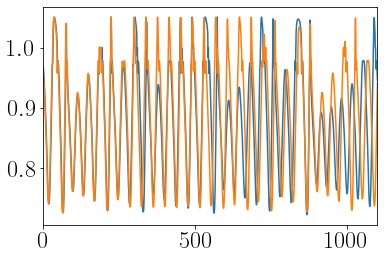

In [23]:
plt.plot(sigradius)
plt.plot(prdradius)
plt.show()

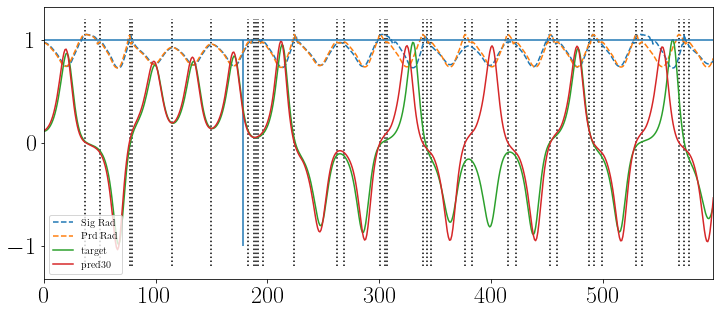

In [33]:
showLen = 600
delYs = np.linalg.norm(uncSig,ord=1,axis=0)
plt.figure(figsize=(12,5))
#plt.plot((delYs-delYs.min())[:showLen], label='delta Y')
plt.plot(sigradius[:showLen],ls='dashed', label='Sig Rad')
plt.plot(prdradius[:showLen],ls='dashed', label='Prd Rad')
plt.plot((target[start:end]/np.max(target[start:end]))[:showLen], label='target')
plt.plot((pred30[start:end]/np.max(pred30[start:end]))[:showLen], label='pred30')
#plt.plot(cNum[:showLen]/cNum[:showLen].max(), label='cond num')
#plt.vlines(argrelmax(delYs[:showLen]), color='k', ymin=-1, ymax=1)
plt.vlines(argrelmax(prdradius[:showLen]),ls='dotted', color='k', ymin=-1.2, ymax=1.2)
plt.vlines([178],ymin=-1,ymax=1)
plt.axhline(1)
plt.legend(loc='lower left')
plt.show()

In [18]:
std = np.std(target[:15000])

nrmse30 = NRMSE(target[14000:15000],pred30[14000:15000],std)
print(f'NRMSE 30: {nrmse30}')

NRMSE 30: 0.9116541864264603


In [19]:
from scipy.special import rel_entr

def distribution(dataP,dataQ,mn,mx, bins=100):
    emptyFlag = []
    measureP,bnlocs = np.histogram(dataP, bins=bins, range=(mn,mx))
    measureQ,_ = np.histogram(dataQ, bins=bins, range=(mn,mx))
    for i in range(bins):
        if((measureP[i] == 0) or (measureQ[i] == 0)):
            emptyFlag.append(False)
        else:
            emptyFlag.append(True)
    #pdb.set_trace()
    measureP = measureP[emptyFlag]
    measureQ = measureQ[emptyFlag]    
    pmfP = (measureP)/np.linalg.norm(measureP)
    pmfQ = (measureQ)/np.linalg.norm(measureQ)
    kl = np.sum(rel_entr(pmfP,pmfQ))
    return (kl,pmfP,pmfQ, bnlocs)

In [21]:
mn,mx = support(target[14000:],pred30[14000:])
kl = distribution(target[14000:], pred30[14000:], -19.5, 19.5, bn)
print(f'KL-div N=30   {kl[0]:.5f}')
print(f'Max {mx}    Min {mn}')

KL-div N=30   0.27875
Max 16.80984878540039    Min -16.754907608032227


In [23]:
list(set((argrelmax(sigradius)[0]).tolist()) & set((np.where(sigradius>1)[0]).tolist()))

[533,
 544,
 38,
 303,
 311,
 187,
 573,
 192,
 1088,
 195,
 453,
 839,
 78,
 718,
 341,
 725,
 727,
 225,
 491,
 878,
 495,
 757]

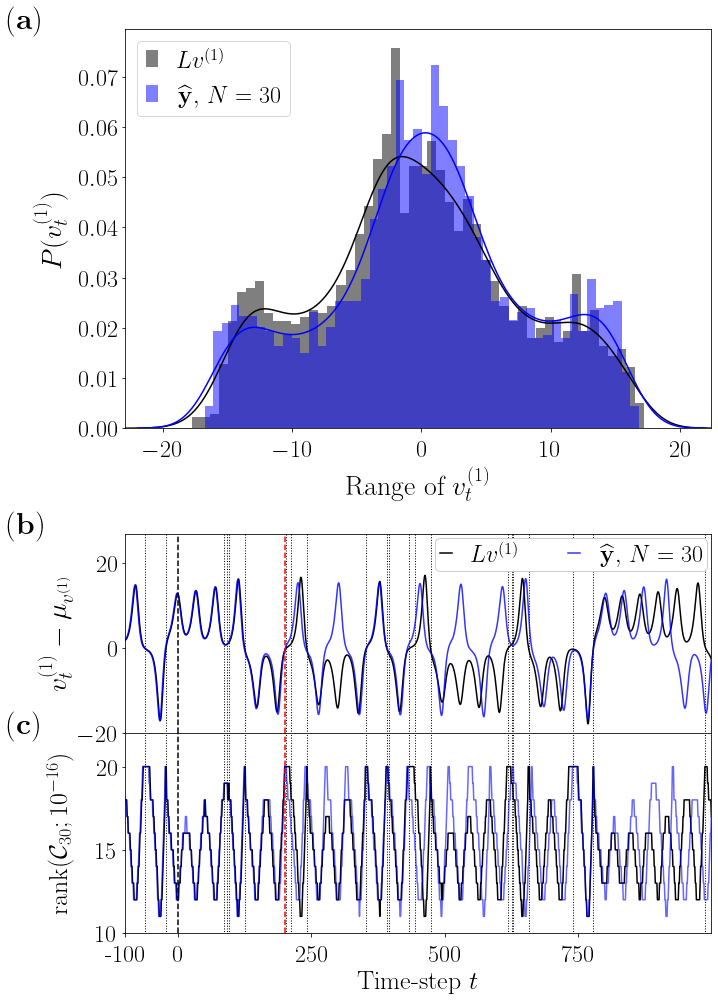

In [27]:
#import string
gs = gridspec.GridSpec(2, 1)
fig = plt.figure(figsize=(10,14))
ax1 = plt.subplot(gs[0])
fontsize = 28


data_dict = {'y': target[14000:],
             'yh30': np.squeeze(pred30[14000:]),
            }
alpha = .5
bins = 50
df = pd.DataFrame(data=data_dict)
sns.distplot(df['y'],
             label='$Lv^{(1)}$',
             bins=bins,
             color='k',
             axlabel=False,
             norm_hist=True,
             hist_kws=dict(alpha=.5),
             ax=ax1)
sns.distplot(df['yh30'],
             label='$\widehat{\mathbf{y}},\,N=30$',
             bins=bins,
             color='b',
             axlabel=False,
             norm_hist=True,
             hist_kws=dict(alpha=alpha),
             ax=ax1)
ax1.legend(handlelength=.5,loc='upper left', fontsize=fontsize-4)
ax1.set_ylabel(r'${P}(v^{(1)}_t)$', fontsize=fontsize,  color='black', weight='heavy', labelpad=10)
ax1.set_xlabel(r'Range of $v^{(1)}_t$', fontsize=fontsize,  color='black', weight='heavy')
ax1.text(-0.2, 1.,s='$(\mathbf{a})$', transform=ax1.transAxes, 
            size=30, weight='bold')



start, end= 13900,15000
xax = [k for k in range(start,end)]
plt.rcParams['xtick.major.pad']='8'
gs1 = gs[1].subgridspec(2,1, hspace=0)
#gs1.update(wspace=0.025, hspace=0.0)

ax2 = plt.subplot(gs1[0])
ax2.plot(xax,target[start:end],'k', label=r'$Lv^{(1)}$')
ax2.plot(xax,pred30[start:end],'b-', label='$\widehat{\mathbf{y}},\,N=30$', alpha = .8)
ax2.set_ylim(-20,27)
ax2.legend(loc='upper right',
           framealpha=1,
           handlelength=.5,
           ncol=2,
           fontsize=24,
           borderpad=.2,
           borderaxespad=.2)

ax2.set_ylabel(r'$v^{(1)}_t-\mu_{v^{(1)}}$', fontsize=fontsize,  color='black', weight='heavy')
ax2.text(-0.2, 1.,s='$(\mathbf{b})$', transform=ax2.transAxes, 
            size=30, weight='bold')
ax2.set_xticks([])

#sig_rks30 = np.load('Consistent/Ranks/X_30_sig_rks30.npy')
#prd_rks30 = np.load('Consistent/Ranks/X_30_prd_rks30.npy')
ax3 = plt.subplot(gs1[1])
ax3.text(-0.2, 0,s='$(\mathbf{c})$', transform=ax2.transAxes, 
            size=30, weight='bold')
ax3.plot(xax,sig_rks30,
        color='k', label='$Lv^{(1)}$', alpha=1.)
ax3.plot(xax,prd_rks30,
        color= 'b', label='$\widehat{\mathbf{y}}$', alpha=.6)
ax3.set_ylim(10, 22)
ax3.set_ylabel('$\mathrm{rank}(\mathbf{\mathcal{C}}_{30};10^{-16})$', labelpad=22)
ax3.set_xlabel('Time-step $t$')
#ax3.legend(handlelength=.5,
#           ncol=2,
#           loc='lower right',
#           fontsize=24,
#           framealpha=1,
#           borderpad=.2,
#           borderaxespad=.2)
ax3.set_xticks([13900,14000,14250,14500,14750])
ax3.set_xticklabels([-100,0,250,500,750])
ax3.set_yticks([10,15,20])

maxradii = list(set((argrelmax(sigradius)[0]).tolist()) & set((np.where(sigradius>1)[0]).tolist())) 

ax2.axvline(14000, c='k',ls='dashed' )
ax2.axvline(14200, c='r',ls='dashed' )
ax2.vlines(np.array(maxradii) + 13900, -25,27, color='k', linewidths=1, ls='dotted')
ax3.vlines(np.array(maxradii) + 13900, 8,22, color='k', linewidths=1, ls='dotted')
ax3.axvline(14000, c='k',ls='dashed' )
ax3.axvline(14200, c='r',ls='dashed' )
plt.tight_layout()
plt.show()
fig.savefig("../ChaosPlots/Lx_lines_combined.pdf", format='pdf', bbox_inches='tight', pad_inches=.01)

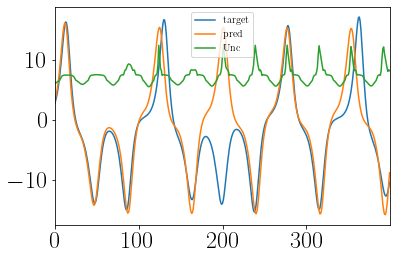

In [52]:
plt.plot(target[14100:14500], label = 'target')
plt.plot(pred30[14100:14500], label='pred')
plt.plot(cNum[100:500], label='Unc')
plt.legend()
plt.show()

In [43]:
np.max(uncPrd,axis=0)

array([0.49502801, 0.49416529, 0.49267859, ..., 0.47836472, 0.48017723,
       0.48658216])

In [77]:
rk = sig_rks30[100:200].reshape((100,1))
sg = target[14100:14200].reshape((100,1))
np.dot(rk.T,sg)/(np.linalg.norm(rk)*np.linalg.norm(sg))

array([[-0.35694675]])

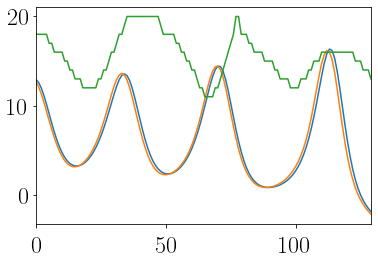

In [78]:
plt.plot(target[14000:14130], label = 'target')
plt.plot(pred30[14000:14130], label='pred')
plt.plot(sig_rks30[:130])
plt.show()

In [79]:
rk = prd_rks30[:130].reshape((130,1))
sg = pred30[14000:14130].reshape((130,1))
np.dot(rk.T,sg)/(np.linalg.norm(rk)*np.linalg.norm(sg))

array([[0.81247525]])

k-size=5 Trainingset min=0.75569  threshold=0.71790  Location=200
k-size=10 Trainingset min=0.91753  threshold=0.87165  Location=198
k-size=20 Trainingset min=0.96525  threshold=0.91699  Location=210
k-size=30 Trainingset min=0.97491  threshold=0.92616  Location=200


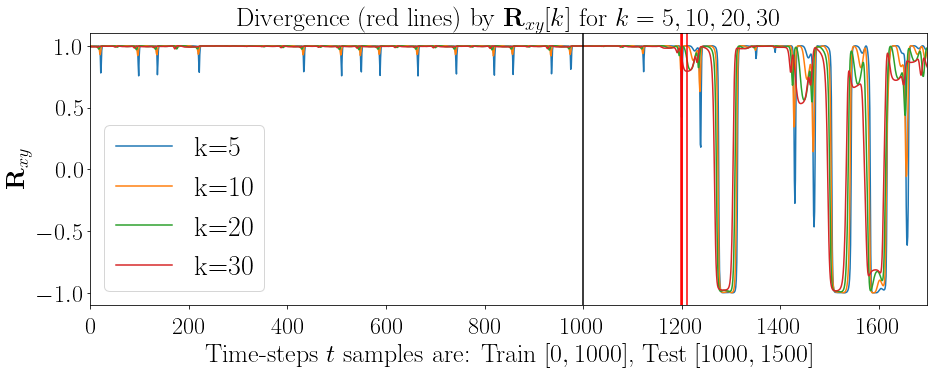

In [80]:
def Rxy(x,y):
    return np.dot(x.T,y)/(np.linalg.norm(x)*np.linalg.norm(y))

k_list = [5,10,20,30]
start, stop = 13000, 15500  #Depends on dataset should be last 1000 train to 500 of free-run
plt.figure(figsize=(15,5))
for k in k_list:
    trainCorr = np.zeros((stop-start)-k)
    for j in range(start, stop-k):
        tar = target[j:j+k].reshape((k,1))
        prd = pred30[j:j+k].reshape((k,1))
        trainCorr[j-start] = Rxy(tar,prd)
    minVal = trainCorr[:1000].min()
    threshold = minVal-(minVal*.05)
    thresholdLoc = np.where(trainCorr[1000:2000]<threshold)[0][0]
    print(f'k-size={k} Trainingset min={trainCorr[:1000].min().round(5)}  threshold={threshold:.5f}',
          f' Location={thresholdLoc}')
    plt.plot(trainCorr[:1700], label=f'k={k}')
    plt.axvline(1000+thresholdLoc,color='r')
plt.ylabel('$\mathbf{R}_{xy}$')
plt.xlabel('Time-steps $t$ samples are: Train $[0,1000]$, Test $[1000,1500]$')
plt.legend(fontsize=28)
plt.axvline(1000,color='k') #End trainset
plt.title('Divergence (red lines) by $\mathbf{R}_{xy}[k]$ for $k=5,10,20,30$')
plt.show()